In [ ]:
import jax
jax.config.update("jax_enable_x64", True)

from jax import numpy as jnp
from jax import vmap, grad, jit
from jax.scipy.special import sph_harm

import s2fft
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt




def colormap(x):
    cmap = plt.get_cmap('viridis', 256)
    return cmap(x)


def normalize(v):
    max = jnp.max(v)
    min = jnp.min(v)
    return (v - min) / (max - min)


def sph_plot(f, theta, phi, ax):
    theta, phi = jnp.meshgrid(theta, phi)
    x, y, z = sph_to_cart(theta, phi)
    ax.plot_surface(x, y, z, facecolors=f, rstride=1, cstride=1, shade=False)


def rotation_plot(alphas, betas, N):
    gammas = jnp.zeros_like(alphas)
    t = jnp.linspace(0, 2*jnp.pi, N+1)[:-1]
    x0, y0, z0 = jnp.cos(t), jnp.sin(t), jnp.zeros_like(t)
    i1, i2 = 0, 5
    
    # Plot sampling points
    plt.figure(figsize=(15, 5))
    
    ax = plt.subplot(141, projection='3d')
    plt.title("Sampled angles")
    ax.scatter(*sph_to_cart(betas, alphas, r=1), color='r')
    
    # Scatter rotated pooints for alpha[i], beta[i] rotation
    ax = plt.subplot(142, projection='3d')
    plt.title("Example rotation 1")
    ax.scatter(*rotate_points(x0, y0, z0, alphas[i1], betas[i1], gammas[i1]), color='r')
    ax.plot(*[[0., p] for p in rotate_point(0, 0, 1., alphas[i1], betas[i1], gammas[i1])], color='b')
    
    ax = plt.subplot(143, projection='3d')
    plt.title("Example rotation 2")
    ax.scatter(*rotate_points(x0, y0, z0, alphas[i2], betas[i2], gammas[i2]), color='r')
    ax.plot(*[[0., p] for p in rotate_point(0, 0, 1., alphas[i2], betas[i2], gammas[i2])], color='b')
    
    ax = plt.subplot(144, projection='3d')
    plt.title("Coverage")
    for i in range(len(alphas)):
        ax.scatter(*rotate_points(x0, y0, z0, alphas[i], betas[i], gammas[i]), color='b')
    ax.scatter(*sph_to_cart(betas, alphas, r=1), color='r')
    ax.view_init(elev=0, azim=90)


def Xrot(alpha):
    return jnp.array([
        [1, 0, 0],
        [0, jnp.cos(alpha), -jnp.sin(alpha)],
        [0, jnp.sin(alpha), jnp.cos(alpha)]
    ])
    
def Yrot(beta):
    return jnp.array([
        [jnp.cos(beta), 0, jnp.sin(beta)],
        [0, 1, 0],
        [-jnp.sin(beta), 0, jnp.cos(beta)]
    ])


def Zrot(gamma):
    return jnp.array([
        [jnp.cos(gamma), -jnp.sin(gamma), 0],
        [jnp.sin(gamma), jnp.cos(gamma), 0],
        [0, 0, 1]
    ])
    

def ZYZrot(alpha, beta, gamma):
    return Zrot(alpha) @ Yrot(beta) @ Zrot(gamma)

def cart_to_sph(x, y, z):
    r = jnp.sqrt(x**2 + y**2 + z**2)
    theta = jnp.arccos(z/r)
    phi = jnp.arctan2(y, x)
    return theta, phi


def sph_to_cart(theta, phi, r=1.):
    x = r * jnp.sin(theta) * jnp.cos(phi)
    y = r * jnp.sin(theta) * jnp.sin(phi)
    z = r * jnp.cos(theta)
    return x, y, z


def rotate_point(x, y, z, alpha, beta, gamma):
    R = ZYZrot(alpha, beta, gamma)
    xyz = (R @ jnp.array([[x, y, z]]).T).squeeze()
    return xyz[0], xyz[1], xyz[2]


def rotate_points(x,y,z, alpha, beta, gamma):
    R = ZYZrot(alpha, beta, gamma)
    xyz = vmap(lambda xi,yi,zi: R @ jnp.array([[xi, yi, zi]]).T)(x, y, z)
    return xyz[:,0], xyz[:,1], xyz[:,2]


def inv_rotate_points(x,y,z, alpha, beta, gamma):
    return rotate_points(x, y, z, -gamma, -beta, -alpha)


def inv_rotate_point(x,y,z,alpha, beta, gamma):
    return rotate_point(x, y, z, -gamma, -beta, -alpha)


def polar_to_rotated(alpha, beta, phi):
    x = jnp.cos(beta)*jnp.cos(alpha)*jnp.cos(phi) - jnp.sin(beta)*jnp.sin(phi)
    y = jnp.sin(beta)*jnp.cos(alpha)*jnp.cos(phi) + jnp.cos(beta)*jnp.sin(phi)
    z = -jnp.sin(alpha)*jnp.cos(phi)
    return x, y, z


def sph_parity_plot(f, thetas, phis):
    plt.figure(figsize=(15, 5))
    
    ax = plt.subplot(141, projection='3d')
    plt.title("Re F(r)")
    v = colormap(normalize(f.real))
    sph_plot(v, thetas, phis, ax)
    
    ax = plt.subplot(142, projection='3d')
    plt.title("Re F(-r)")
    v = colormap(normalize(f.real))
    sph_plot(v, jnp.pi - thetas, phis + jnp.pi, ax)

    ax = plt.subplot(143, projection='3d')
    plt.title("Im F(r)")
    v = colormap(normalize(f.imag))
    sph_plot(v, thetas, phis, ax)

    ax = plt.subplot(144, projection='3d')
    plt.title("Imag F(-r)")
    v = colormap(normalize(-f.imag))
    sph_plot(v, jnp.pi - thetas, phis + jnp.pi, ax)


def eval_shell(theta, phi, fm, ls, ms, L_max):
    # sph_harm uses different conventions for theta and phi
    theta, phi = phi, theta
    return jnp.sum(sph_harm(ms, ls, jnp.array([theta]), jnp.array([phi]), n_max=L_max) * fm)
    #return jnp.sum(basis(ms) * fm)


def sph_rot(fm, alpha, d_beta, gamma, ms):
    return jnp.exp(-1j*ms*alpha) * jnp.einsum('ij,j->i', d_beta, jnp.exp(-1j*ms*gamma) * fm)


def sph_rot_slice(fm, alpha, d_beta, gamma, ms, sph_zero):
    return sph_rot(fm, alpha, d_beta, gamma, ms) * sph_zero


def get_slicing_weights(betas, ms, L):
    d_beta = vmap(lambda beta: s2fft.utils.rotation.generate_rotate_dls(L, beta)[-1, :, :])(betas)
    sph_zero = sph_harm(ms, jnp.ones_like(ms)*L, 0., jnp.pi/2)
    return d_beta, sph_zero


def random_signal(L, key):
    key1, key2 = jax.random.split(key)
    ms = jnp.arange(-(L-1), (L-1)+1).astype(jnp.int32)
    f = jax.random.normal(key1, shape=(2*L-1)) + 1j * jax.random.normal(key2, shape=(2*L-1))
    f = f + (-1)**(L-1-ms)*jnp.conjugate(f[::-1])
    return f

In [65]:
# Indices
L = 11
ms = jnp.arange(-(L-1), (L-1)+1)#.astype(jnp.int32)
ls = jnp.ones_like(ms)*(L-1)

# Eval grid
#thetas = jnp.linspace(0, jnp.pi, 50)
#phis = jnp.linspace(0, 2*jnp.pi, 101)#[:-1]
Lmax, sampling = 41, "mw"
phis = s2fft.sampling.s2_samples.phis_equiang(Lmax, sampling)
thetas = s2fft.sampling.s2_samples.thetas(Lmax, sampling)
Theta, Phi = jnp.meshgrid(thetas, phis)

# Signal
fm = random_signal(L, jax.random.PRNGKey(0))
#fm = fm.at[jnp.abs(ms) != 4].set(0.)


In [66]:
f_wrap = jit(lambda theta, phi: eval_shell(theta, phi, fm, ls, ms, L))
f = vmap(vmap(f_wrap, (0, None)), (None, 0))(thetas, phis)

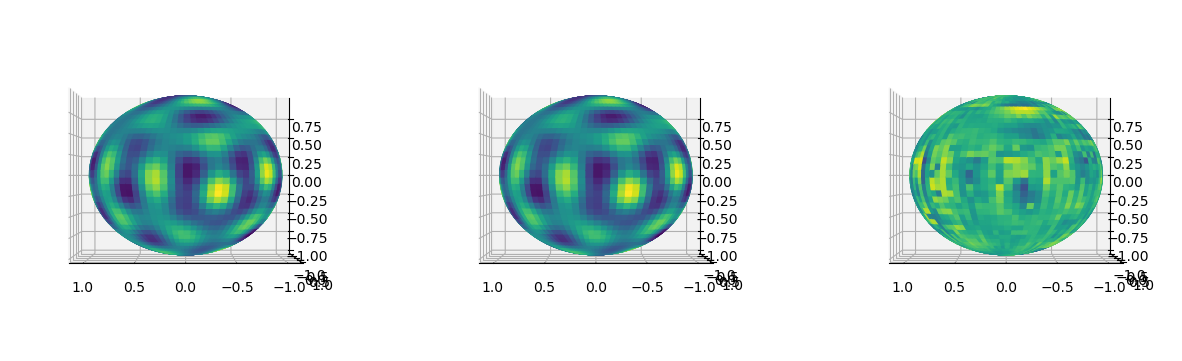

In [71]:
eval_shell_wrap = vmap(lambda thetas, phis: eval_shell(thetas, phis, fm, ls, ms, L), (0, 0))

def f_dom_rot(alpha, beta, gamma):
    f = lambda thetas, phis: f_wrap(*cart_to_sph(*rotate_point(*sph_to_cart(thetas, phis), alpha, beta, gamma)))
    return f

def f_wig_rot(alpha, beta, gamma):
    d_beta = s2fft.utils.rotation.generate_rotate_dls(L, beta)[-1,:, :]
    fm_rot = sph_rot(fm, alpha, d_beta, gamma, ms)
    return lambda thetas, phis: eval_shell(thetas, phis, fm_rot, ls, ms, L)


def f_s2fft_rot(alpha, beta, gamma):
    flm = jnp.zeros((Lmax, 2*Lmax-1), dtype=jnp.complex128)
    flm = s2fft.rotate_flms(flm.at[L-1, ms+Lmax-1].set(fm), Lmax, (alpha, beta, gamma))
    return s2fft.inverse_jax(flm, Lmax, sampling=sampling)


alpha, beta, gamma = 0.0, 0.5*jnp.pi*2, 0.0
f_dom_rot_eval = vmap(vmap(f_dom_rot(alpha, beta, gamma), (0, None)), (None, 0))(thetas, phis).imag
f_wig_rot_eval = vmap(vmap(f_wig_rot(-gamma, -beta, -alpha), (0, None)), (None, 0))(thetas, phis).imag
f_s2fft_rot_eval = f_s2fft_rot(-gamma, -beta, -alpha).imag.T
#f_wig_rot_eval = f_s2fft_rot_eval

v_dom = colormap(normalize(f_dom_rot_eval))
v_wig = colormap(normalize(f_wig_rot_eval))
v_diff = colormap(normalize(f_dom_rot_eval - f_wig_rot_eval))

plt.figure(figsize=(15, 5))
sph_plot(v_dom, thetas, phis, plt.subplot(131, projection='3d'))
plt.gca().view_init(elev=0, azim=90)
sph_plot(v_wig, thetas, phis, plt.subplot(132, projection='3d'))
plt.gca().view_init(elev=0, azim=90)
sph_plot(v_diff, thetas, phis, plt.subplot(133, projection='3d'))
plt.gca().view_init(elev=0, azim=90)
